In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as tvtransforms
import time
import torch
import numpy as np
import segmentation_models_pytorch as smp
import metrics as smpmetrics
import albumentations as A
from tqdm import tqdm
from meter import AverageValueMeter
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import albumentations as A
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp


In [2]:
MULTICLASS_MODE: str = "multiclass"
ENCODER = "resnet18"
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'ocean', 'wetsand', 'buildings', 'vegetation', 'drysand']
ACTIVATION = None
BATCH_SIZE = 2
MODEL_NAME = 'deeplabv3'
EPOCHS = 200
DEVICE = 'cuda'
TRAIN_IMG_DIR = "../../CoastSat/data/blackpool/images/train/"
TRAIN_MASK_DIR = "../../CoastSat/data/blackpool/images/trainannot/"
VAL_IMG_DIR = "../../CoastSat/data/blackpool/images/test/"
VAL_MASK_DIR = "../../CoastSat/data/blackpool/images/testannot/"

In [3]:
avail = torch.cuda.is_available() # just checking which devices are available for training
devCnt = torch.cuda.device_count()
devName = torch.cuda.get_device_name(0)
print("Available: " + str(avail) + ", Count: " + str(devCnt) + ", Name: " + str(devName))

Available: True, Count: 1, Name: NVIDIA GeForce RTX 3070


In [4]:
class Dataset(Dataset):
    """This method creates the dataset from given directories"""
    def __init__(self, image_dir, mask_dir, transform=None):
        """initialize directories

        :image_dir: TODO
        :mask_dir: TODO
        :transform: TODO

        """
        self._image_dir = image_dir
        self._mask_dir = mask_dir
        self._transform = transform
        self.images = os.listdir(image_dir)

        self.mapping = {(0, 0, 0): 0, # background class (black)
                        (0, 0, 255): 1,  # 0 = class 1
                        (225, 0, 225): 2,  # 1 = class 2
                        (255, 0, 0): 3,  # 2 = class 3
                        (255, 225, 225): 4, # 3 = class 4
                        (255, 255, 0): 5}  # 4 = class 5

    def __len__(self):
        """returns length of images
        :returns: TODO

        """
        return len(self.images)
    
    def mask_to_class_rgb(self, mask):
        #print('----mask->rgb----')
        h=20
        w=722
        mask = torch.from_numpy(mask)
        mask = torch.squeeze(mask)  # remove 1

        # check the present values in the mask, 0 and 255 in my case
        #print('unique values rgb    ', torch.unique(mask)) 
        # -> unique values rgb     tensor([  0, 255], dtype=torch.uint8)

        class_mask = mask
        class_mask = class_mask.permute(2, 0, 1).contiguous()
        h, w = class_mask.shape[1], class_mask.shape[2]
        mask_out = torch.zeros(h, w, dtype=torch.long)

        for k in self.mapping:
            idx = (class_mask == torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))         
            validx = (idx.sum(0) == 3)          
            mask_out[validx] = torch.tensor(self.mapping[k], dtype=torch.long)

        # check the present values after mapping, in my case 0, 1, 2, 3PSPNet
        #print('unique values mapped ', torch.unique(mask_out))
        # -> unique values mapped  tensor([0, 1, 2, 3])
       
        return mask_out

    def __getitem__(self, index):
        """TODO: Docstring for __getitem__.
        :returns: TODO

        """
        img_path = os.path.join(self._image_dir, self.images[index])
        mask_path = os.path.join(self._mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))
        mask = self.mask_to_class_rgb(mask).cpu().detach().numpy()


        if self._transform is not None:
            augmentations = self._transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            

        return image, mask

In [5]:
def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    """
    This method creates the dataloader objects for the training loops

    :train_dir: directory of training images
    :train_mask_dir: directory of training masks
    :val_dir: validation image directory

    :returns: training and validation dataloaders
recall
    """
    train_ds = Dataset(image_dir=train_dir,
                             mask_dir=train_mask_dir,
                             transform=train_transform)
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = Dataset(
        image_dir=val_dir,
        mask_dir=val_mask_dir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

In [6]:
    """
    Training and testing image transforms using albumentation libraries
    """
test_transform = A.Compose(
    [A.PadIfNeeded(min_height=32, min_width=512, border_mode=4),A.Resize(32, 512),]
)

train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=32, min_width=512, border_mode=4),
        A.Resize(32, 512),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.1),
    ]
)

In [7]:
# get the dataloaders
trainDL, testDL = get_loaders(TRAIN_IMG_DIR, TRAIN_MASK_DIR,
                                           VAL_IMG_DIR, VAL_MASK_DIR,
                                           BATCH_SIZE, train_transform,
                                           test_transform)


In [8]:


def visualize(**images):
    """Method to generate visualization of the training images
    """
    n = len(images)
    plt.figure(figsize=(16,5))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

torch.Size([32, 512])
torch.Size([3, 32, 512])
{1: 10521, 2: 512, 3: 1274, 4: 3297, 5: 780}
torch.Size([3, 32, 512]) torch.uint8 <class 'torch.Tensor'> torch.Size([32, 512]) torch.int32 <class 'torch.Tensor'> tensor(1, dtype=torch.int32) tensor(255, dtype=torch.uint8) tensor(1, dtype=torch.int32) tensor(5, dtype=torch.int32)


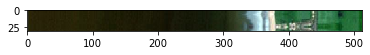

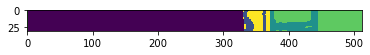

torch.Size([3, 32, 512]) torch.uint8 <class 'torch.Tensor'> torch.Size([32, 512]) torch.int32 <class 'torch.Tensor'> tensor(1, dtype=torch.int32) tensor(255, dtype=torch.uint8) tensor(1, dtype=torch.int32) tensor(5, dtype=torch.int32)
6


In [9]:
transforms_delete = A.Compose([
        A.PadIfNeeded(32,512),
        A.Resize(32, 512),
        ToTensorV2(),
    ], )
dataset = Dataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=transforms_delete)

image, mask = dataset[10] # get some sample

#visualize(
#    image=image,
#    mask=mask.squeeze()
#)
#mask = mask.unsqueeze(0)

print(mask.shape)
print(image.shape)
unique, counts = np.unique(mask, return_counts=True)
print(dict(zip(unique, counts)))
print(image.shape, image.dtype, type(image), mask.shape, 
mask.dtype, type(mask), mask.min(), 
image.max(), mask.min(), mask.max())

plt.imshow(image.permute(1,2,0))
plt.show()

plt.imshow(mask)
plt.show()

#mask = mask.unsqueeze(0)
#print(mask.shape)

print(image.shape, image.dtype, type(image), mask.shape, 
mask.dtype, type(mask), mask.min(), 
image.max(), mask.min(), mask.max())

print(len(CLASSES))


In [10]:
# initialize model
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

In [11]:


loss = smp.losses.DiceLoss(mode="multiclass")
loss.__name__ = 'Dice_loss'

# metrics have been defined in the custom training loop as giving them in a list object did not work for me
metrics = [

]

# define optimizer and learning rate
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)

In [12]:
# training epoch
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics= metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

# testing epoch
test_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [13]:
def check_accuracy(metrics, loader, model, device='cpu'):
    """ Custom method to calculate accuracy of testing data
    :loader: dataloader objects
    :model: model to test
    :device: cpu or gpu
    """

    # define scores to track
    f1_score = 0
    precision_score = 0
    recall_score = 0
    iou_score = 0
    dataset_size = len(testDL.dataset)  # number of images in the dataloader

    model.eval() # set model for evaluation
    with torch.no_grad():  # do not calculate gradients
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            y = y.to(torch.int64)
            x = x.permute(0,3,1,2)
            preds = model(x.float())  # get pixel predictions from image tensor
            preds = torch.argmax(preds, dim=1).unsqueeze(1).int()  # get maximum values of tensor along dimension 1

            tp, fp, fn, tn = smpmetrics.get_stats(preds, y, mode='multiclass', num_classes=6)  # get tp,fp,fn,tn from predictions

            # compute metric
            a = smpmetrics.iou_score(tp, fp, fn, tn, reduction="macro")
            b = smpmetrics.f1_score(tp,fp,fn,tn, reduction='macro')
            c = smpmetrics.precision(tp,fp,fn,tn, reduction='macro')
            d = smpmetrics.recall(tp,fp,fn,tn, reduction='macro')

            iou_score += a
            f1_score += b
            precision_score += c
            recall_score += d

    iou_score /= dataset_size  # averaged score across all images in directory
    f1_score /= dataset_size
    precision_score /= dataset_size
    recall_score /= dataset_size

    
    print('IOU Score: {} | F1 Score: {} | Precision Score: {} | Recall Score: {}'.format(iou_score, f1_score, precision_score, recall_score))
    model.train()


In [14]:
scaler = torch.cuda.amp.GradScaler()

def train_fn(loader, model, optimizer, loss_fn, scaler):
    """ Custom training loop for models

    :loader: dataloader object
    :model: model to train
    :optimizer: training optimizer
    :loss_fn: loss function
    :scaler: scaler object
    :returns:

    """
    loop = tqdm(loader)  # just a nice library to keep track of loops

    for batch_idx, (data, targets) in enumerate(loop):  # iterate through dataset
        data = data.to(device=DEVICE).float() 
        targets = targets.to(device=DEVICE)
        targets = targets.unsqueeze(1)
        data = data.permute(0,3,1,2)  # correct shape for image
        targets = targets.to(torch.int64)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # loss_values.append(loss.item())
        #run['training/batch/loss'].log(loss)

        #update loop
        loop.set_postfix(loss=loss.item())

for epoch in range(EPOCHS):  # run training and accuracy functions and save model
    train_fn(trainDL, model, optimizer, loss, scaler)
    check_accuracy(metrics, testDL, model, DEVICE)
    torch.save(model, './{}.pth'.format(MODEL_NAME))

100%|██████████| 65/65 [00:03<00:00, 18.15it/s, loss=0.368]


IOU Score: 0.3165130913257599 | F1 Score: 0.35927334427833557 | Precision Score: 0.35371679067611694 | Recall Score: 0.37181419134140015


100%|██████████| 65/65 [00:01<00:00, 42.80it/s, loss=0.289]


IOU Score: 0.3200680613517761 | F1 Score: 0.36535030603408813 | Precision Score: 0.38229984045028687 | Recall Score: 0.38247358798980713


100%|██████████| 65/65 [00:01<00:00, 43.51it/s, loss=0.17] 


IOU Score: 0.35423484444618225 | F1 Score: 0.40112170577049255 | Precision Score: 0.396064817905426 | Recall Score: 0.4140934944152832


100%|██████████| 65/65 [00:01<00:00, 43.42it/s, loss=0.149]


IOU Score: 0.3682814836502075 | F1 Score: 0.4133590757846832 | Precision Score: 0.40146785974502563 | Recall Score: 0.433347225189209


100%|██████████| 65/65 [00:01<00:00, 43.05it/s, loss=0.176]


IOU Score: 0.385073184967041 | F1 Score: 0.4267422556877136 | Precision Score: 0.4232068657875061 | Recall Score: 0.4382397532463074


100%|██████████| 65/65 [00:01<00:00, 43.42it/s, loss=0.172] 


IOU Score: 0.3730385899543762 | F1 Score: 0.4173528552055359 | Precision Score: 0.40726542472839355 | Recall Score: 0.4363637864589691


100%|██████████| 65/65 [00:01<00:00, 42.15it/s, loss=0.207] 


IOU Score: 0.38228434324264526 | F1 Score: 0.42411622405052185 | Precision Score: 0.425790399312973 | Recall Score: 0.4325680732727051


100%|██████████| 65/65 [00:01<00:00, 42.24it/s, loss=0.207] 


IOU Score: 0.3878577649593353 | F1 Score: 0.4292258620262146 | Precision Score: 0.42535048723220825 | Recall Score: 0.43901705741882324


100%|██████████| 65/65 [00:01<00:00, 42.48it/s, loss=0.122] 


IOU Score: 0.39271482825279236 | F1 Score: 0.43310537934303284 | Precision Score: 0.4280838966369629 | Recall Score: 0.44252094626426697


100%|██████████| 65/65 [00:01<00:00, 40.10it/s, loss=0.231] 


IOU Score: 0.3885326683521271 | F1 Score: 0.42981404066085815 | Precision Score: 0.41817253828048706 | Recall Score: 0.44873470067977905


100%|██████████| 65/65 [00:01<00:00, 43.94it/s, loss=0.0869]


IOU Score: 0.4091106355190277 | F1 Score: 0.4446924328804016 | Precision Score: 0.4407366216182709 | Recall Score: 0.4509556293487549


100%|██████████| 65/65 [00:01<00:00, 43.32it/s, loss=0.148] 


IOU Score: 0.40733203291893005 | F1 Score: 0.4433189034461975 | Precision Score: 0.44054287672042847 | Recall Score: 0.44882267713546753


100%|██████████| 65/65 [00:01<00:00, 41.05it/s, loss=0.135] 


IOU Score: 0.40641769766807556 | F1 Score: 0.443015992641449 | Precision Score: 0.4345405101776123 | Recall Score: 0.45428356528282166


100%|██████████| 65/65 [00:03<00:00, 16.96it/s, loss=0.135] 


IOU Score: 0.41157275438308716 | F1 Score: 0.44649553298950195 | Precision Score: 0.4422082006931305 | Recall Score: 0.45269274711608887


100%|██████████| 65/65 [00:02<00:00, 26.15it/s, loss=0.157] 


IOU Score: 0.4034707546234131 | F1 Score: 0.4402988851070404 | Precision Score: 0.4396471381187439 | Recall Score: 0.4476359486579895


100%|██████████| 65/65 [00:01<00:00, 33.43it/s, loss=0.127] 


IOU Score: 0.416097491979599 | F1 Score: 0.4498031735420227 | Precision Score: 0.4459415376186371 | Recall Score: 0.4553077816963196


100%|██████████| 65/65 [00:01<00:00, 40.71it/s, loss=0.116] 


IOU Score: 0.4087395668029785 | F1 Score: 0.44398394227027893 | Precision Score: 0.440241277217865 | Recall Score: 0.45173826813697815


100%|██████████| 65/65 [00:01<00:00, 40.89it/s, loss=0.133] 


IOU Score: 0.4040326178073883 | F1 Score: 0.4411645531654358 | Precision Score: 0.43884238600730896 | Recall Score: 0.44599008560180664


100%|██████████| 65/65 [00:01<00:00, 41.83it/s, loss=0.153] 


IOU Score: 0.4098469614982605 | F1 Score: 0.44537681341171265 | Precision Score: 0.4405462145805359 | Recall Score: 0.45251888036727905


100%|██████████| 65/65 [00:01<00:00, 42.43it/s, loss=0.144] 


IOU Score: 0.4065895080566406 | F1 Score: 0.44284161925315857 | Precision Score: 0.4370286464691162 | Recall Score: 0.45096176862716675


100%|██████████| 65/65 [00:01<00:00, 43.20it/s, loss=0.191] 


IOU Score: 0.406851589679718 | F1 Score: 0.44269895553588867 | Precision Score: 0.44175663590431213 | Recall Score: 0.4463830590248108


100%|██████████| 65/65 [00:01<00:00, 43.71it/s, loss=0.124] 


IOU Score: 0.4080008566379547 | F1 Score: 0.4444698691368103 | Precision Score: 0.4375764727592468 | Recall Score: 0.4542468190193176


100%|██████████| 65/65 [00:01<00:00, 43.13it/s, loss=0.123] 


IOU Score: 0.40435728430747986 | F1 Score: 0.4406539499759674 | Precision Score: 0.43504127860069275 | Recall Score: 0.45018649101257324


100%|██████████| 65/65 [00:01<00:00, 41.65it/s, loss=0.0827]


IOU Score: 0.4047326147556305 | F1 Score: 0.44140857458114624 | Precision Score: 0.4379037022590637 | Recall Score: 0.4490681290626526


100%|██████████| 65/65 [00:01<00:00, 43.33it/s, loss=0.101] 


IOU Score: 0.4071784019470215 | F1 Score: 0.4429616332054138 | Precision Score: 0.4447701871395111 | Recall Score: 0.4461429715156555


100%|██████████| 65/65 [00:01<00:00, 41.99it/s, loss=0.0697]


IOU Score: 0.4068499505519867 | F1 Score: 0.4431546628475189 | Precision Score: 0.43754974007606506 | Recall Score: 0.45125383138656616


100%|██████████| 65/65 [00:01<00:00, 39.54it/s, loss=0.0645]


IOU Score: 0.410708487033844 | F1 Score: 0.4454970359802246 | Precision Score: 0.4426812529563904 | Recall Score: 0.44994059205055237


100%|██████████| 65/65 [00:01<00:00, 42.72it/s, loss=0.0934]


IOU Score: 0.40847596526145935 | F1 Score: 0.4444049298763275 | Precision Score: 0.4399993419647217 | Recall Score: 0.45208850502967834


100%|██████████| 65/65 [00:01<00:00, 40.61it/s, loss=0.112] 


IOU Score: 0.40642493963241577 | F1 Score: 0.4427730143070221 | Precision Score: 0.43784794211387634 | Recall Score: 0.4505671560764313


100%|██████████| 65/65 [00:01<00:00, 41.74it/s, loss=0.146] 


IOU Score: 0.40754199028015137 | F1 Score: 0.4428028166294098 | Precision Score: 0.4403219223022461 | Recall Score: 0.44671449065208435


100%|██████████| 65/65 [00:01<00:00, 41.93it/s, loss=0.0667]


IOU Score: 0.4084002375602722 | F1 Score: 0.44371548295021057 | Precision Score: 0.4393300414085388 | Recall Score: 0.4502345025539398


100%|██████████| 65/65 [00:01<00:00, 43.05it/s, loss=0.147] 


IOU Score: 0.40601223707199097 | F1 Score: 0.4423806667327881 | Precision Score: 0.4384526312351227 | Recall Score: 0.44829344749450684


100%|██████████| 65/65 [00:01<00:00, 41.13it/s, loss=0.0792]


IOU Score: 0.41104063391685486 | F1 Score: 0.446157306432724 | Precision Score: 0.441781610250473 | Recall Score: 0.45230206847190857


100%|██████████| 65/65 [00:01<00:00, 42.05it/s, loss=0.108] 


IOU Score: 0.40959301590919495 | F1 Score: 0.4450235366821289 | Precision Score: 0.44288402795791626 | Recall Score: 0.4500959515571594


100%|██████████| 65/65 [00:01<00:00, 41.93it/s, loss=0.078] 


IOU Score: 0.41077375411987305 | F1 Score: 0.44617360830307007 | Precision Score: 0.4418475031852722 | Recall Score: 0.45339399576187134


100%|██████████| 65/65 [00:01<00:00, 41.75it/s, loss=0.0984]


IOU Score: 0.4095427393913269 | F1 Score: 0.44447651505470276 | Precision Score: 0.4432164132595062 | Recall Score: 0.447165310382843


100%|██████████| 65/65 [00:01<00:00, 37.96it/s, loss=0.0604]


IOU Score: 0.4139118194580078 | F1 Score: 0.44851574301719666 | Precision Score: 0.44432419538497925 | Recall Score: 0.45444411039352417


100%|██████████| 65/65 [00:01<00:00, 41.04it/s, loss=0.0839]


IOU Score: 0.41410502791404724 | F1 Score: 0.4482095241546631 | Precision Score: 0.4453231692314148 | Recall Score: 0.45258083939552307


100%|██████████| 65/65 [00:01<00:00, 42.59it/s, loss=0.107] 


IOU Score: 0.4084652364253998 | F1 Score: 0.44471558928489685 | Precision Score: 0.44129323959350586 | Recall Score: 0.45228633284568787


100%|██████████| 65/65 [00:01<00:00, 41.63it/s, loss=0.0501]


IOU Score: 0.4094981551170349 | F1 Score: 0.44488829374313354 | Precision Score: 0.443838894367218 | Recall Score: 0.4471448063850403


100%|██████████| 65/65 [00:01<00:00, 40.33it/s, loss=0.0825]


IOU Score: 0.4087684750556946 | F1 Score: 0.44428807497024536 | Precision Score: 0.4421272277832031 | Recall Score: 0.44807368516921997


100%|██████████| 65/65 [00:01<00:00, 41.14it/s, loss=0.0854]


IOU Score: 0.4080612063407898 | F1 Score: 0.44322890043258667 | Precision Score: 0.44297829270362854 | Recall Score: 0.4453093409538269


100%|██████████| 65/65 [00:01<00:00, 43.66it/s, loss=0.0573]


IOU Score: 0.41269174218177795 | F1 Score: 0.44728484749794006 | Precision Score: 0.4439302980899811 | Recall Score: 0.452124685049057


100%|██████████| 65/65 [00:01<00:00, 43.11it/s, loss=0.111] 


IOU Score: 0.4103391766548157 | F1 Score: 0.445300430059433 | Precision Score: 0.4436127245426178 | Recall Score: 0.4484862685203552


100%|██████████| 65/65 [00:01<00:00, 43.84it/s, loss=0.0559]


IOU Score: 0.3994414508342743 | F1 Score: 0.43809038400650024 | Precision Score: 0.4336512088775635 | Recall Score: 0.44672736525535583


100%|██████████| 65/65 [00:01<00:00, 42.73it/s, loss=0.0699]


IOU Score: 0.41005510091781616 | F1 Score: 0.44506603479385376 | Precision Score: 0.4414197504520416 | Recall Score: 0.45029717683792114


100%|██████████| 65/65 [00:01<00:00, 42.28it/s, loss=0.0795]


IOU Score: 0.40739694237709045 | F1 Score: 0.4428435266017914 | Precision Score: 0.4442357122898102 | Recall Score: 0.4427545964717865


100%|██████████| 65/65 [00:01<00:00, 41.71it/s, loss=0.0626]


IOU Score: 0.40779319405555725 | F1 Score: 0.44300708174705505 | Precision Score: 0.4445316791534424 | Recall Score: 0.44276347756385803


100%|██████████| 65/65 [00:01<00:00, 35.61it/s, loss=0.0793]


IOU Score: 0.4147058427333832 | F1 Score: 0.4486687183380127 | Precision Score: 0.44559693336486816 | Recall Score: 0.4534018635749817


100%|██████████| 65/65 [00:01<00:00, 42.94it/s, loss=0.0916]


IOU Score: 0.413792222738266 | F1 Score: 0.4479888081550598 | Precision Score: 0.4445279538631439 | Recall Score: 0.45368796586990356


100%|██████████| 65/65 [00:01<00:00, 38.11it/s, loss=0.0508]


IOU Score: 0.41630154848098755 | F1 Score: 0.4495457112789154 | Precision Score: 0.4490138590335846 | Recall Score: 0.4513627886772156


100%|██████████| 65/65 [00:01<00:00, 42.95it/s, loss=0.0594]


IOU Score: 0.41185468435287476 | F1 Score: 0.4466780722141266 | Precision Score: 0.44244900345802307 | Recall Score: 0.4530344605445862


100%|██████████| 65/65 [00:01<00:00, 43.03it/s, loss=0.0504]


IOU Score: 0.40783435106277466 | F1 Score: 0.4435978829860687 | Precision Score: 0.44158798456192017 | Recall Score: 0.4474881589412689


100%|██████████| 65/65 [00:01<00:00, 40.98it/s, loss=0.0833]


IOU Score: 0.4114916920661926 | F1 Score: 0.44654592871665955 | Precision Score: 0.4440750479698181 | Recall Score: 0.4505109190940857


100%|██████████| 65/65 [00:01<00:00, 41.71it/s, loss=0.0573]


IOU Score: 0.4127100110054016 | F1 Score: 0.4473536014556885 | Precision Score: 0.4443807005882263 | Recall Score: 0.4520726203918457


100%|██████████| 65/65 [00:01<00:00, 43.66it/s, loss=0.111] 


IOU Score: 0.40740448236465454 | F1 Score: 0.4438825249671936 | Precision Score: 0.4400904178619385 | Recall Score: 0.4503563344478607


100%|██████████| 65/65 [00:01<00:00, 42.73it/s, loss=0.0647]


IOU Score: 0.40730518102645874 | F1 Score: 0.44298726320266724 | Precision Score: 0.4401274621486664 | Recall Score: 0.44755905866622925


100%|██████████| 65/65 [00:01<00:00, 43.73it/s, loss=0.0829]


IOU Score: 0.40610265731811523 | F1 Score: 0.4425473213195801 | Precision Score: 0.44121116399765015 | Recall Score: 0.4471372663974762


100%|██████████| 65/65 [00:01<00:00, 43.73it/s, loss=0.0584]


IOU Score: 0.4125864505767822 | F1 Score: 0.44704490900039673 | Precision Score: 0.4448671340942383 | Recall Score: 0.45126891136169434


100%|██████████| 65/65 [00:01<00:00, 44.27it/s, loss=0.129] 


IOU Score: 0.4071985185146332 | F1 Score: 0.44341692328453064 | Precision Score: 0.44125866889953613 | Recall Score: 0.44816556572914124


100%|██████████| 65/65 [00:01<00:00, 43.66it/s, loss=0.0661]


IOU Score: 0.4114016890525818 | F1 Score: 0.44666990637779236 | Precision Score: 0.4433495104312897 | Recall Score: 0.4523298144340515


100%|██████████| 65/65 [00:01<00:00, 44.27it/s, loss=0.123] 


IOU Score: 0.4171762466430664 | F1 Score: 0.45078355073928833 | Precision Score: 0.4472449719905853 | Recall Score: 0.4563372731208801


100%|██████████| 65/65 [00:01<00:00, 43.04it/s, loss=0.11]  


IOU Score: 0.4181116223335266 | F1 Score: 0.4513021409511566 | Precision Score: 0.44995203614234924 | Recall Score: 0.4546998143196106


100%|██████████| 65/65 [00:01<00:00, 43.86it/s, loss=0.0617]


IOU Score: 0.40854278206825256 | F1 Score: 0.44457799196243286 | Precision Score: 0.4392364025115967 | Recall Score: 0.4523603022098541


100%|██████████| 65/65 [00:01<00:00, 43.54it/s, loss=0.105] 


IOU Score: 0.40500015020370483 | F1 Score: 0.44223347306251526 | Precision Score: 0.4376024603843689 | Recall Score: 0.4496731162071228


100%|██████████| 65/65 [00:01<00:00, 43.99it/s, loss=0.0547]


IOU Score: 0.4129735827445984 | F1 Score: 0.44747763872146606 | Precision Score: 0.44420281052589417 | Recall Score: 0.4525700509548187


100%|██████████| 65/65 [00:01<00:00, 42.65it/s, loss=0.0593]


IOU Score: 0.4098525643348694 | F1 Score: 0.44556984305381775 | Precision Score: 0.44209355115890503 | Recall Score: 0.45103827118873596


100%|██████████| 65/65 [00:01<00:00, 43.85it/s, loss=0.0459]


IOU Score: 0.4099331796169281 | F1 Score: 0.44529253244400024 | Precision Score: 0.44127988815307617 | Recall Score: 0.4510948061943054


100%|██████████| 65/65 [00:01<00:00, 43.60it/s, loss=0.0728]


IOU Score: 0.4090937674045563 | F1 Score: 0.44463688135147095 | Precision Score: 0.4401095509529114 | Recall Score: 0.45145827531814575


100%|██████████| 65/65 [00:01<00:00, 43.48it/s, loss=0.0866]


IOU Score: 0.4081484377384186 | F1 Score: 0.4439590871334076 | Precision Score: 0.4417688846588135 | Recall Score: 0.4476766586303711


100%|██████████| 65/65 [00:01<00:00, 43.91it/s, loss=0.0626]


IOU Score: 0.41114649176597595 | F1 Score: 0.4461532533168793 | Precision Score: 0.4421919286251068 | Recall Score: 0.45235809683799744


100%|██████████| 65/65 [00:01<00:00, 43.95it/s, loss=0.0697]


IOU Score: 0.4144960045814514 | F1 Score: 0.44836100935935974 | Precision Score: 0.4478667378425598 | Recall Score: 0.451154887676239


100%|██████████| 65/65 [00:01<00:00, 43.85it/s, loss=0.04]  


IOU Score: 0.4131775498390198 | F1 Score: 0.44773736596107483 | Precision Score: 0.44489750266075134 | Recall Score: 0.45270758867263794


100%|██████████| 65/65 [00:01<00:00, 43.39it/s, loss=0.068] 


IOU Score: 0.41075438261032104 | F1 Score: 0.44617539644241333 | Precision Score: 0.4440532326698303 | Recall Score: 0.4507670998573303


100%|██████████| 65/65 [00:01<00:00, 43.95it/s, loss=0.0464]


IOU Score: 0.4109122157096863 | F1 Score: 0.4459959864616394 | Precision Score: 0.44189730286598206 | Recall Score: 0.45239973068237305


100%|██████████| 65/65 [00:01<00:00, 42.80it/s, loss=0.0923]


IOU Score: 0.41596001386642456 | F1 Score: 0.4498189091682434 | Precision Score: 0.44471874833106995 | Recall Score: 0.45750951766967773


100%|██████████| 65/65 [00:01<00:00, 42.77it/s, loss=0.0566]


IOU Score: 0.41337093710899353 | F1 Score: 0.447551965713501 | Precision Score: 0.4449681341648102 | Recall Score: 0.4521036148071289


100%|██████████| 65/65 [00:01<00:00, 43.55it/s, loss=0.107] 


IOU Score: 0.40580520033836365 | F1 Score: 0.4420285224914551 | Precision Score: 0.440467894077301 | Recall Score: 0.4467640817165375


100%|██████████| 65/65 [00:01<00:00, 43.58it/s, loss=0.0719]


IOU Score: 0.40997475385665894 | F1 Score: 0.4451237618923187 | Precision Score: 0.44186630845069885 | Recall Score: 0.4506412148475647


100%|██████████| 65/65 [00:01<00:00, 43.91it/s, loss=0.0969]


IOU Score: 0.41563814878463745 | F1 Score: 0.4494864344596863 | Precision Score: 0.44742757081985474 | Recall Score: 0.45357924699783325


100%|██████████| 65/65 [00:01<00:00, 43.71it/s, loss=0.0642]


IOU Score: 0.4077327251434326 | F1 Score: 0.44402894377708435 | Precision Score: 0.44241204857826233 | Recall Score: 0.44794711470603943


100%|██████████| 65/65 [00:01<00:00, 43.93it/s, loss=0.114] 


IOU Score: 0.4097818434238434 | F1 Score: 0.44496679306030273 | Precision Score: 0.4412658214569092 | Recall Score: 0.4507632255554199


100%|██████████| 65/65 [00:01<00:00, 43.31it/s, loss=0.0688]


IOU Score: 0.4092841148376465 | F1 Score: 0.44484633207321167 | Precision Score: 0.44083794951438904 | Recall Score: 0.4510577321052551


100%|██████████| 65/65 [00:01<00:00, 43.55it/s, loss=0.0753]


IOU Score: 0.4143353998661041 | F1 Score: 0.4481443762779236 | Precision Score: 0.4440348148345947 | Recall Score: 0.45357489585876465


100%|██████████| 65/65 [00:01<00:00, 42.72it/s, loss=0.102] 


IOU Score: 0.41078582406044006 | F1 Score: 0.4461989998817444 | Precision Score: 0.4471781849861145 | Recall Score: 0.44722217321395874


100%|██████████| 65/65 [00:01<00:00, 42.36it/s, loss=0.0641]


IOU Score: 0.4150264263153076 | F1 Score: 0.4492575526237488 | Precision Score: 0.44394659996032715 | Recall Score: 0.4565928876399994


100%|██████████| 65/65 [00:01<00:00, 43.30it/s, loss=0.0434]


IOU Score: 0.4135476052761078 | F1 Score: 0.448072612285614 | Precision Score: 0.44263091683387756 | Recall Score: 0.455653578042984


100%|██████████| 65/65 [00:01<00:00, 43.57it/s, loss=0.0807]


IOU Score: 0.41049832105636597 | F1 Score: 0.4462386667728424 | Precision Score: 0.44193100929260254 | Recall Score: 0.4535216689109802


100%|██████████| 65/65 [00:01<00:00, 43.30it/s, loss=0.0741]


IOU Score: 0.4122105538845062 | F1 Score: 0.4473344683647156 | Precision Score: 0.4429667592048645 | Recall Score: 0.4541963040828705


100%|██████████| 65/65 [00:01<00:00, 43.60it/s, loss=0.124] 


IOU Score: 0.4156665802001953 | F1 Score: 0.4492867588996887 | Precision Score: 0.44792991876602173 | Recall Score: 0.45229753851890564


100%|██████████| 65/65 [00:01<00:00, 43.52it/s, loss=0.0596]


IOU Score: 0.4140896797180176 | F1 Score: 0.4485977292060852 | Precision Score: 0.4415000081062317 | Recall Score: 0.4586832523345947


100%|██████████| 65/65 [00:01<00:00, 43.38it/s, loss=0.0668]


IOU Score: 0.41334062814712524 | F1 Score: 0.4479268193244934 | Precision Score: 0.4433300495147705 | Recall Score: 0.4543369710445404


100%|██████████| 65/65 [00:01<00:00, 43.10it/s, loss=0.076] 


IOU Score: 0.411185085773468 | F1 Score: 0.44636136293411255 | Precision Score: 0.4436109662055969 | Recall Score: 0.45108652114868164


100%|██████████| 65/65 [00:01<00:00, 43.52it/s, loss=0.0471]


IOU Score: 0.4148447513580322 | F1 Score: 0.44871124625205994 | Precision Score: 0.4472137987613678 | Recall Score: 0.4522060453891754


100%|██████████| 65/65 [00:01<00:00, 43.39it/s, loss=0.0887]


IOU Score: 0.41229137778282166 | F1 Score: 0.4473188519477844 | Precision Score: 0.44467654824256897 | Recall Score: 0.45192670822143555


100%|██████████| 65/65 [00:01<00:00, 42.59it/s, loss=0.0508]


IOU Score: 0.4116501212120056 | F1 Score: 0.4465198516845703 | Precision Score: 0.4409262239933014 | Recall Score: 0.45435038208961487


100%|██████████| 65/65 [00:01<00:00, 43.91it/s, loss=0.087] 


IOU Score: 0.4120982587337494 | F1 Score: 0.4471646249294281 | Precision Score: 0.43993622064590454 | Recall Score: 0.4569832384586334


100%|██████████| 65/65 [00:01<00:00, 43.59it/s, loss=0.0781]


IOU Score: 0.4163796305656433 | F1 Score: 0.4497993588447571 | Precision Score: 0.447620689868927 | Recall Score: 0.4534572660923004


100%|██████████| 65/65 [00:01<00:00, 43.72it/s, loss=0.0487]


IOU Score: 0.41368913650512695 | F1 Score: 0.44835495948791504 | Precision Score: 0.4438895583152771 | Recall Score: 0.4550253450870514


100%|██████████| 65/65 [00:01<00:00, 44.00it/s, loss=0.0733]


IOU Score: 0.4098321497440338 | F1 Score: 0.4452745318412781 | Precision Score: 0.44176873564720154 | Recall Score: 0.4505060315132141


100%|██████████| 65/65 [00:01<00:00, 42.91it/s, loss=0.0381]


IOU Score: 0.41135984659194946 | F1 Score: 0.4467630982398987 | Precision Score: 0.44215860962867737 | Recall Score: 0.453685998916626


100%|██████████| 65/65 [00:01<00:00, 43.72it/s, loss=0.0496]


IOU Score: 0.4068809151649475 | F1 Score: 0.44290751218795776 | Precision Score: 0.4381888806819916 | Recall Score: 0.4504512846469879


100%|██████████| 65/65 [00:01<00:00, 43.27it/s, loss=0.051] 


IOU Score: 0.4124692976474762 | F1 Score: 0.44715794920921326 | Precision Score: 0.4439234733581543 | Recall Score: 0.45190224051475525


100%|██████████| 65/65 [00:01<00:00, 43.61it/s, loss=0.0435]


IOU Score: 0.4100383222103119 | F1 Score: 0.4451780319213867 | Precision Score: 0.44264549016952515 | Recall Score: 0.44903311133384705


100%|██████████| 65/65 [00:01<00:00, 42.65it/s, loss=0.0626]


IOU Score: 0.41767412424087524 | F1 Score: 0.4506913721561432 | Precision Score: 0.4468332827091217 | Recall Score: 0.4561432898044586


100%|██████████| 65/65 [00:01<00:00, 43.60it/s, loss=0.0649]


IOU Score: 0.4149554669857025 | F1 Score: 0.448677122592926 | Precision Score: 0.4460713863372803 | Recall Score: 0.4524090886116028


100%|██████████| 65/65 [00:01<00:00, 42.94it/s, loss=0.0566]


IOU Score: 0.4166313707828522 | F1 Score: 0.45013731718063354 | Precision Score: 0.44698458909988403 | Recall Score: 0.4552640914916992


100%|██████████| 65/65 [00:01<00:00, 43.11it/s, loss=0.0696]


IOU Score: 0.4105793833732605 | F1 Score: 0.4456472396850586 | Precision Score: 0.44271039962768555 | Recall Score: 0.450488805770874


100%|██████████| 65/65 [00:01<00:00, 42.84it/s, loss=0.0638]


IOU Score: 0.40911799669265747 | F1 Score: 0.4448186755180359 | Precision Score: 0.44318658113479614 | Recall Score: 0.44868212938308716


100%|██████████| 65/65 [00:01<00:00, 43.42it/s, loss=0.0573]


IOU Score: 0.41254329681396484 | F1 Score: 0.44728049635887146 | Precision Score: 0.44088515639305115 | Recall Score: 0.4558676779270172


100%|██████████| 65/65 [00:01<00:00, 43.29it/s, loss=0.0568]


IOU Score: 0.407696008682251 | F1 Score: 0.4442642629146576 | Precision Score: 0.43762636184692383 | Recall Score: 0.4543069005012512


100%|██████████| 65/65 [00:01<00:00, 43.45it/s, loss=0.0579]


IOU Score: 0.4098997712135315 | F1 Score: 0.445199579000473 | Precision Score: 0.4394773542881012 | Recall Score: 0.4528502821922302


100%|██████████| 65/65 [00:01<00:00, 43.51it/s, loss=0.0556]


IOU Score: 0.40943893790245056 | F1 Score: 0.4450758993625641 | Precision Score: 0.4395321309566498 | Recall Score: 0.4529057443141937


100%|██████████| 65/65 [00:01<00:00, 43.33it/s, loss=0.0531]


IOU Score: 0.40341705083847046 | F1 Score: 0.4413989186286926 | Precision Score: 0.4338212013244629 | Recall Score: 0.4527814984321594


100%|██████████| 65/65 [00:01<00:00, 42.58it/s, loss=0.074] 


IOU Score: 0.4126463830471039 | F1 Score: 0.4472833275794983 | Precision Score: 0.44359731674194336 | Recall Score: 0.4526752829551697


100%|██████████| 65/65 [00:01<00:00, 43.10it/s, loss=0.119] 


IOU Score: 0.4124116003513336 | F1 Score: 0.44725221395492554 | Precision Score: 0.4426897168159485 | Recall Score: 0.4538772702217102


100%|██████████| 65/65 [00:01<00:00, 42.66it/s, loss=0.062] 


IOU Score: 0.4079338014125824 | F1 Score: 0.44429245591163635 | Precision Score: 0.43806177377700806 | Recall Score: 0.45317354798316956


100%|██████████| 65/65 [00:01<00:00, 41.87it/s, loss=0.0788]


IOU Score: 0.4123014807701111 | F1 Score: 0.4472653865814209 | Precision Score: 0.44342461228370667 | Recall Score: 0.4531545042991638


100%|██████████| 65/65 [00:01<00:00, 43.52it/s, loss=0.0479]


IOU Score: 0.40893086791038513 | F1 Score: 0.44516581296920776 | Precision Score: 0.4418869614601135 | Recall Score: 0.45140472054481506


100%|██████████| 65/65 [00:01<00:00, 43.24it/s, loss=0.0495]


IOU Score: 0.41502314805984497 | F1 Score: 0.4490266442298889 | Precision Score: 0.4459204077720642 | Recall Score: 0.45402535796165466


100%|██████████| 65/65 [00:01<00:00, 43.42it/s, loss=0.0758]


IOU Score: 0.41379642486572266 | F1 Score: 0.4483190178871155 | Precision Score: 0.44352006912231445 | Recall Score: 0.4551564157009125


100%|██████████| 65/65 [00:01<00:00, 43.02it/s, loss=0.0609]


IOU Score: 0.4133337438106537 | F1 Score: 0.44788819551467896 | Precision Score: 0.44231635332107544 | Recall Score: 0.4551641047000885


100%|██████████| 65/65 [00:01<00:00, 43.01it/s, loss=0.103] 


IOU Score: 0.41321414709091187 | F1 Score: 0.4479266107082367 | Precision Score: 0.44269341230392456 | Recall Score: 0.45485591888427734


100%|██████████| 65/65 [00:01<00:00, 41.97it/s, loss=0.0597]


IOU Score: 0.4151148796081543 | F1 Score: 0.4489741325378418 | Precision Score: 0.44586071372032166 | Recall Score: 0.45362138748168945


100%|██████████| 65/65 [00:01<00:00, 42.97it/s, loss=0.0475]


IOU Score: 0.4141108989715576 | F1 Score: 0.4488244950771332 | Precision Score: 0.4447469711303711 | Recall Score: 0.45585116744041443


100%|██████████| 65/65 [00:01<00:00, 43.52it/s, loss=0.0463]


IOU Score: 0.4145251214504242 | F1 Score: 0.44881147146224976 | Precision Score: 0.445338636636734 | Recall Score: 0.4541054666042328


100%|██████████| 65/65 [00:01<00:00, 43.06it/s, loss=0.0406]


IOU Score: 0.41455039381980896 | F1 Score: 0.44856515526771545 | Precision Score: 0.44525375962257385 | Recall Score: 0.45355334877967834


100%|██████████| 65/65 [00:01<00:00, 43.67it/s, loss=0.0687]


IOU Score: 0.4173886179924011 | F1 Score: 0.4510626792907715 | Precision Score: 0.4468074440956116 | Recall Score: 0.45693284273147583


100%|██████████| 65/65 [00:01<00:00, 43.36it/s, loss=0.0674]


IOU Score: 0.4166030287742615 | F1 Score: 0.4500589966773987 | Precision Score: 0.4474943280220032 | Recall Score: 0.4541715085506439


100%|██████████| 65/65 [00:01<00:00, 43.29it/s, loss=0.0418]


IOU Score: 0.4178263247013092 | F1 Score: 0.45088738203048706 | Precision Score: 0.44731706380844116 | Recall Score: 0.45588311553001404


100%|██████████| 65/65 [00:01<00:00, 42.42it/s, loss=0.0613]


IOU Score: 0.4124436378479004 | F1 Score: 0.44695964455604553 | Precision Score: 0.4429144859313965 | Recall Score: 0.4528624415397644


100%|██████████| 65/65 [00:01<00:00, 43.61it/s, loss=0.0653]


IOU Score: 0.41383790969848633 | F1 Score: 0.4480810761451721 | Precision Score: 0.4450039863586426 | Recall Score: 0.4524465501308441


100%|██████████| 65/65 [00:01<00:00, 42.56it/s, loss=0.0439]


IOU Score: 0.41627436876296997 | F1 Score: 0.4499124586582184 | Precision Score: 0.44581475853919983 | Recall Score: 0.45580458641052246


100%|██████████| 65/65 [00:01<00:00, 42.10it/s, loss=0.0562]


IOU Score: 0.4147220551967621 | F1 Score: 0.44858449697494507 | Precision Score: 0.4451799988746643 | Recall Score: 0.45356565713882446


100%|██████████| 65/65 [00:01<00:00, 43.11it/s, loss=0.0575]


IOU Score: 0.4155260920524597 | F1 Score: 0.4492916166782379 | Precision Score: 0.4462195932865143 | Recall Score: 0.4537418782711029


100%|██████████| 65/65 [00:01<00:00, 43.30it/s, loss=0.0495]


IOU Score: 0.4107850193977356 | F1 Score: 0.4460301995277405 | Precision Score: 0.4428110122680664 | Recall Score: 0.4510571360588074


100%|██████████| 65/65 [00:01<00:00, 43.51it/s, loss=0.0518]


IOU Score: 0.41493621468544006 | F1 Score: 0.449044793844223 | Precision Score: 0.44380322098731995 | Recall Score: 0.45599475502967834


100%|██████████| 65/65 [00:01<00:00, 42.15it/s, loss=0.0692]


IOU Score: 0.41593629121780396 | F1 Score: 0.44934144616127014 | Precision Score: 0.4475676119327545 | Recall Score: 0.4526163935661316


100%|██████████| 65/65 [00:01<00:00, 42.68it/s, loss=0.0431]


IOU Score: 0.4124721884727478 | F1 Score: 0.4471217691898346 | Precision Score: 0.4460994601249695 | Recall Score: 0.4495483338832855


100%|██████████| 65/65 [00:01<00:00, 42.55it/s, loss=0.0589]


IOU Score: 0.4134189188480377 | F1 Score: 0.44769811630249023 | Precision Score: 0.44584766030311584 | Recall Score: 0.4510461390018463


100%|██████████| 65/65 [00:01<00:00, 43.36it/s, loss=0.0595]


IOU Score: 0.4028739035129547 | F1 Score: 0.4412267804145813 | Precision Score: 0.4348483681678772 | Recall Score: 0.45229649543762207


100%|██████████| 65/65 [00:01<00:00, 42.95it/s, loss=0.0486]


IOU Score: 0.4112936854362488 | F1 Score: 0.4461090564727783 | Precision Score: 0.4420245289802551 | Recall Score: 0.45162734389305115


100%|██████████| 65/65 [00:01<00:00, 41.59it/s, loss=0.0527]


IOU Score: 0.40767842531204224 | F1 Score: 0.4438919425010681 | Precision Score: 0.44046783447265625 | Recall Score: 0.449895441532135


100%|██████████| 65/65 [00:01<00:00, 43.11it/s, loss=0.058] 


IOU Score: 0.41119369864463806 | F1 Score: 0.44626110792160034 | Precision Score: 0.44150370359420776 | Recall Score: 0.4532589912414551


100%|██████████| 65/65 [00:01<00:00, 42.73it/s, loss=0.0613]


IOU Score: 0.41115322709083557 | F1 Score: 0.44642171263694763 | Precision Score: 0.4438180923461914 | Recall Score: 0.4512876868247986


100%|██████████| 65/65 [00:01<00:00, 42.93it/s, loss=0.0624]


IOU Score: 0.4120742678642273 | F1 Score: 0.44681888818740845 | Precision Score: 0.4432859420776367 | Recall Score: 0.4521735608577728


100%|██████████| 65/65 [00:01<00:00, 43.07it/s, loss=0.0619]


IOU Score: 0.41760921478271484 | F1 Score: 0.4505771994590759 | Precision Score: 0.44693517684936523 | Recall Score: 0.4553963243961334


100%|██████████| 65/65 [00:01<00:00, 42.70it/s, loss=0.0454]


IOU Score: 0.41699734330177307 | F1 Score: 0.4498545229434967 | Precision Score: 0.4451829791069031 | Recall Score: 0.45620113611221313


100%|██████████| 65/65 [00:01<00:00, 42.73it/s, loss=0.0808]


IOU Score: 0.41117873787879944 | F1 Score: 0.4465522766113281 | Precision Score: 0.44422823190689087 | Recall Score: 0.4509298801422119


100%|██████████| 65/65 [00:01<00:00, 41.86it/s, loss=0.0471]


IOU Score: 0.4088137745857239 | F1 Score: 0.4451375901699066 | Precision Score: 0.44070982933044434 | Recall Score: 0.45236891508102417


100%|██████████| 65/65 [00:01<00:00, 43.39it/s, loss=0.0506]


IOU Score: 0.40831437706947327 | F1 Score: 0.44438743591308594 | Precision Score: 0.44024866819381714 | Recall Score: 0.4513019025325775


100%|██████████| 65/65 [00:01<00:00, 41.48it/s, loss=0.0365]


IOU Score: 0.4101138710975647 | F1 Score: 0.4457221031188965 | Precision Score: 0.4417434334754944 | Recall Score: 0.45213666558265686


100%|██████████| 65/65 [00:01<00:00, 42.72it/s, loss=0.0909]


IOU Score: 0.4091551899909973 | F1 Score: 0.44500046968460083 | Precision Score: 0.43998607993125916 | Recall Score: 0.4523828625679016


100%|██████████| 65/65 [00:01<00:00, 43.07it/s, loss=0.0672]


IOU Score: 0.41051405668258667 | F1 Score: 0.4459569454193115 | Precision Score: 0.44095101952552795 | Recall Score: 0.4528788626194


100%|██████████| 65/65 [00:01<00:00, 42.85it/s, loss=0.0703]


IOU Score: 0.4076624810695648 | F1 Score: 0.443697988986969 | Precision Score: 0.4382835924625397 | Recall Score: 0.45148223638534546


100%|██████████| 65/65 [00:01<00:00, 43.03it/s, loss=0.0699]


IOU Score: 0.41162651777267456 | F1 Score: 0.44674915075302124 | Precision Score: 0.4432355761528015 | Recall Score: 0.45217132568359375


100%|██████████| 65/65 [00:01<00:00, 43.16it/s, loss=0.0847]


IOU Score: 0.41146332025527954 | F1 Score: 0.4462708532810211 | Precision Score: 0.44428524374961853 | Recall Score: 0.4496902525424957


100%|██████████| 65/65 [00:01<00:00, 42.10it/s, loss=0.0648]


IOU Score: 0.4115831255912781 | F1 Score: 0.4467236399650574 | Precision Score: 0.4435666501522064 | Recall Score: 0.45237311720848083


100%|██████████| 65/65 [00:02<00:00, 29.55it/s, loss=0.0678]


IOU Score: 0.4073692262172699 | F1 Score: 0.44415217638015747 | Precision Score: 0.4390856623649597 | Recall Score: 0.4527941644191742


100%|██████████| 65/65 [00:01<00:00, 38.25it/s, loss=0.051] 


IOU Score: 0.4140078127384186 | F1 Score: 0.4481784403324127 | Precision Score: 0.44464507699012756 | Recall Score: 0.4535905718803406


100%|██████████| 65/65 [00:01<00:00, 41.28it/s, loss=0.0537]


IOU Score: 0.4128854274749756 | F1 Score: 0.4474165439605713 | Precision Score: 0.44393667578697205 | Recall Score: 0.4529067575931549


100%|██████████| 65/65 [00:01<00:00, 42.10it/s, loss=0.0929]


IOU Score: 0.4131777882575989 | F1 Score: 0.44806647300720215 | Precision Score: 0.4436301290988922 | Recall Score: 0.4550654888153076


100%|██████████| 65/65 [00:01<00:00, 41.85it/s, loss=0.0451]


IOU Score: 0.4116179049015045 | F1 Score: 0.44701337814331055 | Precision Score: 0.442260205745697 | Recall Score: 0.4540749490261078


100%|██████████| 65/65 [00:01<00:00, 41.82it/s, loss=0.0627]


IOU Score: 0.41056913137435913 | F1 Score: 0.4459003806114197 | Precision Score: 0.44226017594337463 | Recall Score: 0.4513373374938965


100%|██████████| 65/65 [00:01<00:00, 41.44it/s, loss=0.0497]


IOU Score: 0.4118320047855377 | F1 Score: 0.44687288999557495 | Precision Score: 0.44231748580932617 | Recall Score: 0.453532874584198


100%|██████████| 65/65 [00:01<00:00, 41.61it/s, loss=0.0681]


IOU Score: 0.4148136079311371 | F1 Score: 0.44888249039649963 | Precision Score: 0.44481611251831055 | Recall Score: 0.4548560082912445


100%|██████████| 65/65 [00:01<00:00, 41.84it/s, loss=0.069] 


IOU Score: 0.4132457375526428 | F1 Score: 0.447688490152359 | Precision Score: 0.4434289038181305 | Recall Score: 0.4540657103061676


100%|██████████| 65/65 [00:01<00:00, 41.30it/s, loss=0.0689]


IOU Score: 0.4121672511100769 | F1 Score: 0.4467995762825012 | Precision Score: 0.44340968132019043 | Recall Score: 0.45192450284957886


100%|██████████| 65/65 [00:01<00:00, 42.33it/s, loss=0.0305]


IOU Score: 0.41631555557250977 | F1 Score: 0.4496294856071472 | Precision Score: 0.4468221068382263 | Recall Score: 0.45415011048316956


100%|██████████| 65/65 [00:01<00:00, 42.47it/s, loss=0.0543]


IOU Score: 0.4163251519203186 | F1 Score: 0.44986873865127563 | Precision Score: 0.4471339285373688 | Recall Score: 0.4544070363044739


100%|██████████| 65/65 [00:01<00:00, 42.24it/s, loss=0.0817]


IOU Score: 0.4136934280395508 | F1 Score: 0.4481547474861145 | Precision Score: 0.44473543763160706 | Recall Score: 0.45373886823654175


100%|██████████| 65/65 [00:01<00:00, 41.63it/s, loss=0.0361]


IOU Score: 0.41109028458595276 | F1 Score: 0.44635313749313354 | Precision Score: 0.44248491525650024 | Recall Score: 0.4525722563266754


100%|██████████| 65/65 [00:01<00:00, 42.62it/s, loss=0.0409]


IOU Score: 0.4116894602775574 | F1 Score: 0.44684451818466187 | Precision Score: 0.44196271896362305 | Recall Score: 0.45384636521339417


100%|██████████| 65/65 [00:01<00:00, 41.48it/s, loss=0.0386]


IOU Score: 0.41069936752319336 | F1 Score: 0.4462767243385315 | Precision Score: 0.44134464859962463 | Recall Score: 0.4535323679447174


100%|██████████| 65/65 [00:01<00:00, 41.36it/s, loss=0.044] 


IOU Score: 0.41518086194992065 | F1 Score: 0.44924992322921753 | Precision Score: 0.44658559560775757 | Recall Score: 0.4534870684146881


100%|██████████| 65/65 [00:01<00:00, 40.15it/s, loss=0.0843]


IOU Score: 0.41041094064712524 | F1 Score: 0.44572409987449646 | Precision Score: 0.4420854151248932 | Recall Score: 0.4513212740421295


100%|██████████| 65/65 [00:01<00:00, 42.57it/s, loss=0.0278]


IOU Score: 0.4095165729522705 | F1 Score: 0.44510021805763245 | Precision Score: 0.4419308602809906 | Recall Score: 0.4496920704841614


100%|██████████| 65/65 [00:01<00:00, 41.00it/s, loss=0.0733]


IOU Score: 0.4105551242828369 | F1 Score: 0.4456826150417328 | Precision Score: 0.44156351685523987 | Recall Score: 0.45160913467407227


100%|██████████| 65/65 [00:01<00:00, 42.06it/s, loss=0.0518]


IOU Score: 0.4172523021697998 | F1 Score: 0.4507041573524475 | Precision Score: 0.44965940713882446 | Recall Score: 0.4537580907344818


100%|██████████| 65/65 [00:01<00:00, 42.02it/s, loss=0.0774]


IOU Score: 0.4096044600009918 | F1 Score: 0.44486790895462036 | Precision Score: 0.44184383749961853 | Recall Score: 0.45042285323143005


100%|██████████| 65/65 [00:01<00:00, 42.15it/s, loss=0.0243]


IOU Score: 0.4115843176841736 | F1 Score: 0.4464469850063324 | Precision Score: 0.44372645020484924 | Recall Score: 0.45098114013671875


100%|██████████| 65/65 [00:01<00:00, 41.99it/s, loss=0.107] 


IOU Score: 0.4135247766971588 | F1 Score: 0.44770413637161255 | Precision Score: 0.445397287607193 | Recall Score: 0.4514389634132385


100%|██████████| 65/65 [00:01<00:00, 42.35it/s, loss=0.0605]


IOU Score: 0.4119049906730652 | F1 Score: 0.446972131729126 | Precision Score: 0.4435192942619324 | Recall Score: 0.45220884680747986


100%|██████████| 65/65 [00:01<00:00, 42.19it/s, loss=0.0227]


IOU Score: 0.4112478196620941 | F1 Score: 0.4461379647254944 | Precision Score: 0.44212809205055237 | Recall Score: 0.45198336243629456


100%|██████████| 65/65 [00:01<00:00, 42.32it/s, loss=0.0951]


IOU Score: 0.4126880168914795 | F1 Score: 0.4474109709262848 | Precision Score: 0.4435293674468994 | Recall Score: 0.4532049298286438


100%|██████████| 65/65 [00:01<00:00, 41.72it/s, loss=0.0485]


IOU Score: 0.41460976004600525 | F1 Score: 0.4486478865146637 | Precision Score: 0.44549599289894104 | Recall Score: 0.4531916677951813


100%|██████████| 65/65 [00:01<00:00, 42.50it/s, loss=0.0481]


IOU Score: 0.4090234637260437 | F1 Score: 0.4450228810310364 | Precision Score: 0.4414140582084656 | Recall Score: 0.45018330216407776


100%|██████████| 65/65 [00:01<00:00, 41.17it/s, loss=0.0575]


IOU Score: 0.41028451919555664 | F1 Score: 0.44562625885009766 | Precision Score: 0.4427129626274109 | Recall Score: 0.45028647780418396


100%|██████████| 65/65 [00:01<00:00, 42.46it/s, loss=0.111] 


IOU Score: 0.41728734970092773 | F1 Score: 0.4506685137748718 | Precision Score: 0.4477819800376892 | Recall Score: 0.4552000164985657


100%|██████████| 65/65 [00:01<00:00, 42.69it/s, loss=0.0396]


IOU Score: 0.4165741503238678 | F1 Score: 0.45002222061157227 | Precision Score: 0.4460204541683197 | Recall Score: 0.45583096146583557


100%|██████████| 65/65 [00:01<00:00, 42.67it/s, loss=0.0532]


IOU Score: 0.4138878881931305 | F1 Score: 0.4482812285423279 | Precision Score: 0.4451518952846527 | Recall Score: 0.4531744420528412


100%|██████████| 65/65 [00:01<00:00, 42.68it/s, loss=0.0459]


IOU Score: 0.41095179319381714 | F1 Score: 0.44637060165405273 | Precision Score: 0.4430038332939148 | Recall Score: 0.451875776052475


100%|██████████| 65/65 [00:01<00:00, 42.42it/s, loss=0.0666]


IOU Score: 0.4111751616001129 | F1 Score: 0.44636091589927673 | Precision Score: 0.44365620613098145 | Recall Score: 0.4510602056980133


100%|██████████| 65/65 [00:01<00:00, 39.94it/s, loss=0.0635]


IOU Score: 0.41696929931640625 | F1 Score: 0.4503903388977051 | Precision Score: 0.4483570158481598 | Recall Score: 0.4537206292152405


100%|██████████| 65/65 [00:01<00:00, 40.76it/s, loss=0.0518]


IOU Score: 0.4116593897342682 | F1 Score: 0.4467831254005432 | Precision Score: 0.4421270489692688 | Recall Score: 0.45351043343544006


100%|██████████| 65/65 [00:01<00:00, 43.46it/s, loss=0.0323]


IOU Score: 0.41519373655319214 | F1 Score: 0.4488406181335449 | Precision Score: 0.4460413455963135 | Recall Score: 0.45313748717308044


100%|██████████| 65/65 [00:01<00:00, 43.47it/s, loss=0.0665]


IOU Score: 0.4133768081665039 | F1 Score: 0.44786420464515686 | Precision Score: 0.4439505934715271 | Recall Score: 0.4531952738761902


100%|██████████| 65/65 [00:01<00:00, 42.87it/s, loss=0.0874]


IOU Score: 0.4146758019924164 | F1 Score: 0.4487048089504242 | Precision Score: 0.4447144865989685 | Recall Score: 0.4543296694755554


100%|██████████| 65/65 [00:01<00:00, 43.14it/s, loss=0.0736]


IOU Score: 0.4080204367637634 | F1 Score: 0.44416746497154236 | Precision Score: 0.4381963312625885 | Recall Score: 0.452802836894989


100%|██████████| 65/65 [00:01<00:00, 43.36it/s, loss=0.0606]


IOU Score: 0.4118286967277527 | F1 Score: 0.44664233922958374 | Precision Score: 0.44296517968177795 | Recall Score: 0.45240283012390137


In [15]:
# Predict using saved model

val_transform = A.Compose(  # validation image transforms
    [A.Resize(32, 512),ToTensorV2()]
)

val_image = Image.open('../../CoastSat/data/blackpool/images/val/tile_0-2960.png')

#val_image.show()

transformed = val_transform(image=np.array(val_image))
image_transformed = transformed['image']
batch_tensor = torch.unsqueeze(image_transformed, 0)





In [16]:
model = torch.load('./{}.pth'.format(MODEL_NAME))  # load model

stack all tiled validation images together and save image as predictions

In [17]:
# import required module
import os
# assign directory
directory = '../../CoastSat/data/blackpool/images/val/'
image_matrix = np.zeros(shape=(32,512))


# iterate over files in
# that directory
for filename in sorted(os.listdir(directory)):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        val_image = Image.open(f)
        transformed = val_transform(image=np.array(val_image))
        image_transformed = transformed['image']
        batch_tensor = torch.unsqueeze(image_transformed, 0)
        out = model(batch_tensor.to(device=DEVICE).float())

        preds = torch.argmax(out, dim=1)
        preds = preds.cpu().detach().permute(1,2,0)
        preds = preds[:,:,0]

        preds_np = preds.numpy()

        image_matrix = np.vstack((image_matrix, preds_np))

image_matrix = image_matrix[32:,:]
plt.imshow(image_matrix)
plt.savefig('blackpool_preds_{}.png'.format(MODEL_NAME))
plt.show()


        
        
        

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

Now do the same for the rgb image. 

Image size is 32,512,3 - so you have to divide the final tensor object by 255 for matplotlib to plot the rgb original image.

In [ ]:
directory = '../../CoastSat/data/blackpool/images/val/'
image_matrix1 = np.zeros(shape=(32,512,3))
#print(image_matrix.shape)
#testmat = np.vstack((image_matrix, preds.numpy()))

 
# iterate over files in
# that directory
for filename in sorted(os.listdir(directory)):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        val_image = Image.open(f)
        transformed = val_transform(image=np.array(val_image))
        image_transformed = transformed['image']
        img3 = image_transformed.permute(1,2,0)
        #img3 = img3[:,:,0]
        print(img3.shape)
        image_matrix1 = np.vstack((image_matrix1,img3))

image_matrix1 = image_matrix1[32:,:]/255
plt.imshow(image_matrix1)
plt.savefig('blackpool_gt_rgb_{}.png'.format(MODEL_NAME))
plt.show()

Finally, get the ground truth masks basically same as above

In [ ]:
# import required module
import os
# assign directory
directory3 = '../../CoastSat/data/blackpool/images/valannot/'
image_matrix3 = np.zeros(shape=(32,512,3))


# iterate over files in
# that directory
for filename in sorted(os.listdir(directory3)):
    f = os.path.join(directory3, filename)
    # checking if it is a file
    if os.path.isfile(f):
        val_image = Image.open(f)
        transformed = val_transform(image=np.array(val_image))
        image_transformed = transformed['image']
        img3 = image_transformed.permute(1,2,0)
        image_matrix3 = np.vstack((image_matrix3, img3))


image_matrix3 = image_matrix3[32:,:]
plt.imshow(image_matrix3)
plt.savefig('blackpool_gt_mask_{}.png'.format(MODEL_NAME))
plt.show()